# Training the House Plant Model
The purpose of this notebook is to allow modifications to the model to be made without having to re-run every kernel

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

# Imports
import os, warnings
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from pathlib import Path
import imghdr

In [3]:
# Load dataset
dataset_path = "house_plant_species"

# only keep supported formats like .jpg, .jpeg, .png
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']

### Removing Unwanted Data
Tensor Flow is very picky with what data it wants. This code block only needs to be ran once but allowed me to remove the data that did not work from the directory `house_plant_species`

In [ ]:
# sourced from: https://stackoverflow.com/questions/68191448/unknown-image-file-format-one-of-jpeg-png-gif-bmp-required
from pathlib import Path
import imghdr

# Point to current directories and valid types
data_dir = dataset_path
image_extensions = valid_extensions  

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

### Loading the Data
Next, we'll load all of the data to be ready for training.

In [4]:
# Set up reproducibility
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

ds_train_ = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 13724 files belonging to 47 classes.


I0000 00:00:1734561688.992052  154538 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 13724 files belonging to 47 classes.


### Training
Next, we'll train and take a look at the model's performance using some augmented training data. Some warnings arise due to incorrect `sRGB`profiles; however this will not affect the model's accuracy or performance so I will ignore it for the most part.

In [5]:
# Define the model
num_classes = 47  # Update this based on your dataset's number of classes

model = keras.Sequential([
    layers.InputLayer(shape=[128, 128, 3]),

    # Data Augmentation
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(factor=0.10),

    # Block One
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),  # Multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use categorical crossentropy for multi-class
    metrics=['accuracy'],
)

# Train the model
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=0,
)

I0000 00:00:1734561703.723172  155099 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-18 17:41:47.962295: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: eXIf: duplicate
2024-12-18 17:41:48.556734: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-18 17:41:48.694422: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-18 17:41:58.242410: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-18 17:42:01.928437: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-18 17:42:02.654779: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-18 17:42:04.715485: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-18 17:42:05.130632: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-12-1

### Plotting and Understanding the Data
Finally, it is a good idea to observe the accuracy of the model to see whether any issues of over or under fitting arise.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,070,695 (107.08 MB)

 Trainable params: 9,356,597 (35.69 MB)

 Non-trainable params: 902 (3.52 KB)

 Optimizer params: 18,713,196 (71.39 MB)

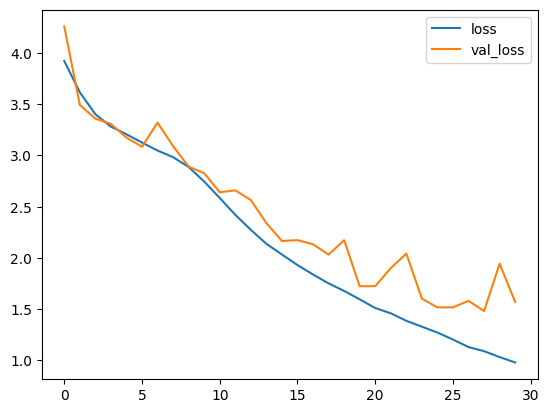

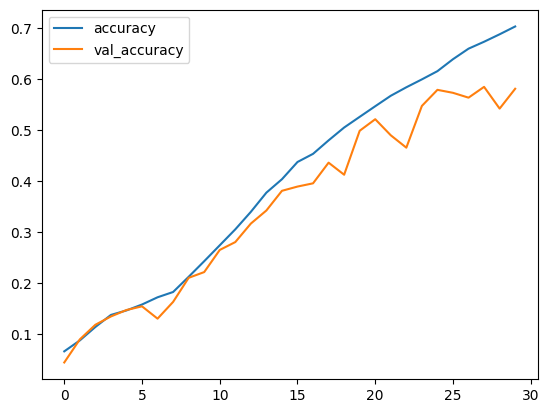

In [6]:
# Plot training history
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

# Print model summary to verify architecture
model.summary()

### Saving and Exporting the Model
Now that I am satisfied with the output of the model, I will save the model for use in my main program.

In [ ]:
model.save('path_to_save_model/my_model')